Log important changes:
- 5 Sep
    - Notebook created to bring ngsim experiment scripts for highd deployment
    - Goal is to run experiments for icra 2020 submission
- 14 Sep
    - Make the jld2 index file
    - sample vehicles that drive together

In [18]:
# usings
using NGSIM
using AutomotiveDrivingModels
using AutoViz
using Interact # Make video in notebook
using Reel # Save video as gif
using CSV # For writing to csv
using DataFrames # For writing to csv
using Distributions
using Test
using StatsBase
using Dates
using Plots
using JLD
using DelimitedFiles # To write to text file
using LinearAlgebra # For norm
using Random # For seed to enable repeatability
using NPZ # For providing numpy readable data to RansML
using FileIO # For writing index file to jld2

In [2]:
# Bring in the functions defined in admin_functions.jl
include("admin_functions.jl");

In [9]:
# Loading: roads and trajectories
traj_highd = open(io->read(io, MIME"text/plain"(), Trajdata), 
    "trajdata_Data11_Road1_nLIOD3_lower.txt", "r");
# The highd roadway geometry
roadway_highd = open(io->read(io, MIME"text/plain"(), Roadway), 
    "highd_roadway.txt", "r");
timestep_highd = 0.04;

# Functions

In [32]:
# Functions: sample initial particles, noise addition, keep vehicle ids, get scene
"""
    function sample_init_particles(num_p::Int64;v=30.0)

Inspired from `gen_test_particles` in `admin.jl`.
Samples `num_p` particles neighbourhood around the input `v`

# Used by
- `multistep_update`

# Example
```julia
sample_init_particles(10,v=20.0)
```
"""
function sample_init_particles(num_p::Int64;v::Float64=30.0)
    v_particles = sample(v-2.0:0.5:v+2.0,num_p)
    sig_particles = sample(1.0:0.1:5.0,num_p)
    p_set_dict = Dict(:v_des=>v_particles,:σ=>sig_particles)
    return p_set_dict
end

"""
    function get_scene(framenum::Int64,traj)

Get a specific scene from traj_ngsim

# Used by
- `multistep_update`

# Example:
```julia
scene = get_scene(1,traj_ngsim)
```
"""
function get_scene(framenum::Int64,traj)
    scene = Scene(500)
    get!(scene,traj,framenum)
    return scene
end

"""
    function get_veh_info(scene;car_id = -1)

Get position and velocity of specific vehicle from scene

# Used by
- `multistep_update`

# Example
```julia
scene = get_highd_scene(7)
pos,vel = get_veh_info(scene,car_id = 6)
@show pos,vel
```
"""
function get_veh_info(scene;car_id = -1)
    @assert car_id>0
    pos = scene.entities[findfirst(car_id,scene)].state.posG.x
    vel = scene.entities[findfirst(car_id,scene)].state.v
    return pos,vel
end

"""
    function keep_vehicle_subset!(scene::Scene, ids::Vector{Int})
Will come in useful to remove those vehicles from video who we do not learn filter for.
Obtained from `ngsim_env/julia/src/ngsim_utils.jl`

# Arguments
- `ids` List of integers with ids of vehicles to be kept
- `scene` A scene in which to keep vehicles given in `ids` and remove the rest of the vehicles

# Used by
- `run_simulation` Only keep those vehicles in the scene for which we have done filtering

# Example
```julia
scene = Scene(500)
get!(scene,traj_ngsim,300)
keep_vehicle_subset!(scene,veh_id_list)
```
"""
function keep_vehicle_subset!(scene::Scene, ids)
    keep_ids = Set(ids)
    scene_ids = Set([veh.id for veh in scene])
    remove_ids = setdiff(scene_ids, keep_ids)
    for id in remove_ids
        delete!(scene, id)
    end
    return scene
end

"""
    function avg_dist_particles(p_mat,p_fin)
Compute the avg distance over particle set from final particle

# Arguments
- `p_mat`: Matrix with particles in every column
- `p_fin`: 2x1 array with the final particle

# Example:
- See `obtain_driver_models`
"""
function avg_dist_particles(p_mat,p_fin)
    return sum(sqrt.(sum((p_mat .- p_fin).^2,dims=1)))*1/size(p_mat,2)
end

"""
    function addnoise
Add noise to elite particles to counter the particle deprivation problem
- Used by `multistep_update`
# Arguments
- `p_set_mat`: Matrix with each column being a particle. Row1 has `v_des` and row2 has `sigma`
- `weight_vec`: Associated weight for particles. To capture the elite 20% for noise addition 

# Returns
- `new_set` Set of particles with noise added

# Example
See `multistep_update`
```julia
num_p = 10
v = 30.
v_particles = rand(v-5.0:0.5:v+5.0,1,num_p)
sig_particles = rand(0.1:0.1:3.0,1,num_p)
p_set = [v_particles;sig_particles]
@show p_set
scatter(p_set[1,:],p_set[2,:],xlim=(22,36),ylim=(0,4),leg=false,markercolor = "red")
new_p = addnoise(p_set)
@show new_p
scatter!(new_p[1,:],new_p[2,:],xlim=(22,36),ylim=(0,4),leg=false,markercolor="green")
```
"""
function addnoise(p_set_mat,weight_vec)
    # Select the elite particles
    num_p = size(p_set_mat,2)
    num_top = Int(ceil(0.2*num_p))
    
    sorted_idx = sortperm(weight_vec,rev=true)[1:num_top] 
    
    # Generate permuter for v_des and sigma
    v_noise = rand([-0.5,0.,0.5],1,num_top)
    sig_noise = rand([-0.1,0.,0.1],1,num_top)
    stacked_noise = [v_noise;sig_noise]
    
    # Add noise only to the elite particles i.e top 20% particles
    p_set_mat[:,sorted_idx] = p_set_mat[:,sorted_idx] + stacked_noise
    new_set = p_set_mat
    
    # Impose bounds to avoid sigma becoming 0
    new_set[2,findall(new_set[2,:] .< 0.1)] .= 0.1
    return new_set
end

"""
    function to_rec_form(start_frame,last_frame,dt=0.04)
Extract ngsim scenes into scenerecord. To enable rmse calculations

# Arguments
- `start_frame` Frame number to start from
- `last_frame` Frame number to end at

# Returns
- `truerec` Scenerecord containing the highd scenes from start_frame to last_frame

# Example
```julia
truerec = to_rec_form(301,400)

    # Render the starting frame (notice the backward indexing) and then last frame
render(truerec.frames[99],roadway_highd,[IDOverlay(colorant"white",12)])
render(truerec.frames[1],roadway_highd,[IDOverlay(colorant"white",12)])
```
"""
function to_rec_form(start_frame,last_frame,dt=0.1)
    num_frames = last_frame-start_frame+1
    truerec = SceneRecord(num_frames,dt)
    count = num_frames
    for i in start_frame:last_frame
        scene = Scene(500)
        scene = get_ngsim_scene(i)
        truerec.frames[count] = scene
        count=count-1
    end
    return truerec
end

to_rec_form

In [11]:
# Functions: hallucinate,likelihood computation,update particles a step
"""
    function hallucinate_a_step(roadway,scene_input,particle;car_id=-1)
- Hallucinate `car_id` a step using `particle` starting from `scene` as the true scene
- Caution: Used `timestep_ngsim` as a global variable

# Example
```julia
scene=get_scene(300,traj_highd)
particle = Dict(:v_des=>25.0,:σ=>0.5)
hallucinate_a_step(roadway_highd,scene,particle,car_id=scene.entities[2].id)
```
"""
function hallucinate_a_step(roadway,scene_input,particle;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end

    scene = deepcopy(scene_input)
    #scene = scene_input # This was the failure case
    n_cars = scene.n 

    models = Dict{Int, DriverModel}()
    
    # Create driver models for all the cars in the scene
    for veh in scene
        if veh.id == car_id
            models[veh.id] = IntelligentDriverModel(;particle...,T=0.2,s_min=0.5)
        else
            # TODO: RESEARCH QUESTION: What drives the other vehicles in the hallucination
            # Chose a high v_des such that the leader does not cause ego to choose a slow vel particle
            models[veh.id] = IntelligentDriverModel(v_des=50.0)
        end
    end

    actions = Array{Any}(undef,length(scene))
    get_actions!(actions,scene,roadway,models)
    tick!(scene,roadway,actions,timestep_highd)
    
    halluc_pos = scene.entities[findfirst(car_id,scene)].state.posG.x
    return halluc_pos
end

"""

# Caution
- `timestep` defined in the function. Was 0.04 for highd. Here is 0.1
"""
function compute_particle_likelihoods(roadway,f,trupos,p_set_dict;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end
    p_mat, params, vec_val_vec = to_matrix_form(p_set_dict)
    
    num_params=size(p_mat)[1]
    num_p = size(p_mat)[2]
    lkhd_vec = Array{Float64}(undef,num_p)
    for i in 1:num_p    
        # Create dict version for a single particle
        p_dict = Dict()
        for j in 1:num_params
            p_dict[params[j]]=vec_val_vec[j][i]
        end
        
        std_dev_acc = p_dict[:σ]
        
        # hack to avoid the std_dev_pos become negative and error Normal distb
        if std_dev_acc <= 0 std_dev_acc = 0.1 end
        
        # TODO: This math needs to be verified from random variable calculations
        std_dev_pos = timestep_highd*timestep_highd*std_dev_acc

        hpos = hallucinate_a_step(roadway,f,p_dict,car_id=car_id)
        lkhd_vec[i] = pdf(Normal(hpos,std_dev_pos),trupos[1])
    end
    return lkhd_vec,p_mat,params
end

"""
    function update_p_one_step(roadway,f,trupos,p_set_dict;car_id=-1)
New particle set based on one step of resampling

# Returns
- `new_p_set_dict`: Dictionary with keys as parameters and values as array of particles
- `p_weight_vec`: Vector with weights associated to the particles in `new_p_set_dict`
"""
function update_p_one_step(roadway,f,trupos,p_set_dict;car_id=-1)
    if car_id==-1 @show "Provide valid car_id" end

    lkhd_vec,p_mat,params = compute_particle_likelihoods(roadway,f,trupos,p_set_dict,
                                                        car_id=car_id)

    num_params = size(p_mat)[1]
    num_p = size(p_mat)[2]

    ll_vec = log.(lkhd_vec)
    
    # TODO: This is hacky. What if log is not negative
    for i in 1:num_p
        if isinf(ll_vec[i])
            ll_vec[i] = 0
        else
            ll_vec[i] = -1*1/ll_vec[i]
        end
    end
    
    p_weight_vec = weights(ll_vec./sum(ll_vec)) # Convert to weights form to use julia sampling
    idx = sample(1:num_p,p_weight_vec,num_p)
    new_p_mat = p_mat[:,idx] #Careful that idx is (size,1) and not (size,2)
    
    new_p_set_dict = to_dict_form(params,new_p_mat)
    return new_p_set_dict, p_weight_vec
end

update_p_one_step

In [51]:
# Functions: plot_particles,my_overlay,IDoverlay,make videos, plot carwise pos vel
"""
    function plot_particles(p_set_mat::Array{Float64,2},time::Float64)

Plot the distribution of particles
# Caution 
Only work for 2 parameters. Not developed for 3 parameter case yet

# Used by
- `multistep_update`

# Example:
```julia
set_for_plotting = to_particleMatrix(p_set_new)
plots = []
push!(plots,plot_particles(set_for_plotting,framenum*0.04))
```
"""
function plot_particles(p_set_mat::Array{Float64,2},time::Float64)
    # Check that number of params does not exceed 3

    @assert size(p_set_mat,1) <= 3
    plt = Plots.plot()
    # 2 parameter case	
    if size(p_set_mat,1) == 2
        plt = scatter(p_set_mat[1,:],p_set_mat[2,:],
            leg=false,title="time=$(time)",xlim=(0,20),ylim=(0,4),
                xlabel="v_des(m/s)",ylabel="sigma")

    # 3 parameter case
    else
        plt = scatter(p_set_mat[1,:],p_set_mat[2,:],p_set_mat[3,:],leg=false)
        scatter!([true_params[1]],[true_params[2]],[true_params[3]])
    end
    return plt
end

"""
    function make_gif(plots;filename="output.mp4")
Make a video using an array of plots. Uses the Reel library

# Used by
- `multistep_update`
"""
function make_gif(plots;filename="output.mp4")
@assert typeof(filename) == String
#@show "Making gif"
    frames = Frames(MIME("image/png"), fps=10)
    for plt in plots
        push!(frames, plt)
    end
    write(string("media/",filename), frames)
    return nothing
end # End of the reel gif writing function

"""
    my_overlay
Overlaying hallucinated trajectory on the ground truth
# Fields
- `color::Colorant`
- `scene::Scene`
"""
struct my_overlay <: SceneOverlay
    scene::Scene
    color # Needs to be of form colorant"Colorname"
end

function AutoViz.render!(rendermodel::RenderModel,overlay::my_overlay, 
        scene::Scene, roadway::Roadway)
    AutoViz.render!(rendermodel,overlay.scene,car_color = overlay.color)
    return rendermodel
end

"""
    IDOverlay
Display the ID on top of each entity in a scene.
# Fields
- `color::Colorant`
- `font_size::Int64`
"""
mutable struct IDOverlay <: SceneOverlay
    color::Colorant
    font_size::Int
end

function AutoViz.render!(rendermodel::RenderModel, overlay::IDOverlay, scene::Scene, 
                            env::E) where E
    font_size = overlay.font_size
    for veh in scene
        add_instruction!(rendermodel, render_text, ("$(veh.id)", veh.state.posG.x, 
                        veh.state.posG.y, font_size, overlay.color), incameraframe=true)
    end
    return rendermodel
end

"""
    function make_video(;range=nothing,filename="ngsim_$(range).mp4")

Makes a video of the ngsim dataset on the ngsim roadway taking frame range as input

# Overlays
- Id number of all vehicles
- Timestep as a text overlay

# Example
```julia
make_video(range=1010:1110)
```
"""
function make_video(;range=nothing,traj=traj_highd,roadway=roadway_highd,filename="media/highd_vids/$(range).mp4")

    frames = Frames(MIME("image/png"), fps=10)
    scene = Scene(500)
    for i in range
        temp_scene = get_scene(i,traj)
        
        scene_visual = render(temp_scene, roadway,
            [IDOverlay(colorant"white",10),TextOverlay(text=["frame=$(i)"],font_size=12)],
            #cam=CarFollowCamera{Int}(51,2.0),
            #cam=StaticCamera(VecE2(1966600, 570750), 1.4),
            cam=FitToContentCamera(-0.6),
        )
        push!(frames,scene_visual)
    end
    write(filename,frames)
    print("Making video called $filename")
    
    return nothing
end


"""
    function video_gail_idm_truth(gail_scenes;start_step,nsteps,roadway,timestep,id_list,models)
- Load in the SceneRecord created by running gail on multiagent_ngsim_env_videomaker
- Overlay the gail scene in addition to true scene on top of hallucinated scene

# Arguments
- `rec_gail::Array`: Array with scenes from gail stored in them. Thankfull in order and not reversed

# Returns
- Writes a video file to `media/for_icra/`

# Made obsolete by
- `run_simulation_extract_rmse`

# Examples
```julia
gail_scenes = load("store_scenes.jld","store_scenes")
video_gail_idm_truth(gail_scenes; start_step=300, nsteps=100, roadway=roadway_ngsim, 
    timestep=timestep_ngsim, id_list=veh_id_list, models=models)
```
"""
function video_gail_idm_truth(gail_scenes;start_step,nsteps,roadway,timestep,id_list,models)
        # Setting up    
    frames = Frames(MIME("image/png"), fps=7) # For making video
    
    scene_halluc = get_scene(start_step,traj_ngsim) # Frame to start hallucination from
    
    for (i,t) in enumerate(start_step:start_step+nsteps-1)
        
        if !isempty(id_list) keep_vehicle_subset!(scene_halluc,id_list) end

        demo_scene_target = get_scene(t+1,traj_ngsim)
        if !isempty(id_list) keep_vehicle_subset!(demo_scene_target,id_list) end
        
        actions = Array{Any}(undef,length(scene_halluc))

            # Propagation of scene forward
        get_actions!(actions,scene_halluc,roadway,models)
        tick!(scene_halluc,roadway,actions,timestep)

            # Load in the gail scene
        gail_scene = gail_scenes[i]
        if !isempty(id_list) keep_vehicle_subset!(gail_scene,id_list) end
        
            # Video stuff
        demo_overlay = my_overlay(demo_scene_target,colorant"white")
        gail_overlay = my_overlay(gail_scene,colorant"blue")
        scene_visual = render(scene_halluc, roadway_ngsim,
                [demo_overlay,gail_overlay,
                IDOverlay(colorant"white",12),TextOverlay(text=["step=$step"],font_size = 14)],
                #cam=CarFollowCamera{Int}(2,5.0),
                cam=FitToContentCamera(-1.5))
        push!(frames,scene_visual)
    end
    write(string("media/for_icra/vid_gail_idm.mp4"),frames) # Save the video

    return nothing
end

"""
    function plot_carwise_pos_vel(car_list,scene_list;start_frame)
- Analyze the frenet `s` and velocity trace for cars in `car_list` starting with frame number `start_frame`
- `scene_list` is a list of scenes generated using our driver model to be compared against ground truth

# Returns
- `plt`: Plot of step vs position for hallucinated cars and true cars
- `plt_vel`: Plot of step vs velocity for hallucinated cars and true cars

# Examples
```julia
car_list = [763,784,767]
pp,vp = plot_carwise_pos_vel(car_list,i_scene_list,start_frame=2000)
display(pp)
```
"""
function plot_carwise_pos_vel(car_list,scene_list;start_frame)
    plt = plot()
    plt_vel = plot()
    frame_num = start_frame
    for id in car_list
        vels = []
        positions = []
        positions_true = []
        vels_true = []
        frame_num = 2000
        for scene in scene_list
            pos,vel = get_veh_info(scene,car_id=id)
            pos_true,vel_true = get_veh_info(get_scene(frame_num,traj_ngsim),car_id=id)

            push!(positions,pos)
            push!(vels,vel)
            push!(positions_true,pos_true)
            push!(vels_true,vel_true)
            frame_num=frame_num+1
        end
        plot!(plt,positions,label="$(id)",title="Position trace")
        plot!(plt,positions_true,label="$(id)_true")
        plot!(plt_vel,vels,label="$(id)",title="Velocity trace")
        plot!(plt_vel,vels_true,label="$(id)_true")

    end
    return plt,plt_vel
end

plot_carwise_pos_vel

In [28]:
# Functions: rmse computation and manipulation
"""
    function rmse_pos_vel(truerec,simrec,veh_id_list)
Capture `rmse_pos` and `rmse_vel` metrics
# Arguments
- `truerec`: ngsim scenes in a scenerecord called truerec
- `simrec`: Hallucinated scenerecord

# Returns
- `rmse_pos`: n_stepsx1 vector with `rmse_pos` averaged over cars for every step
- `rmse_vel`: n_stepsx1 vector with `rmse_vel` averaged over cars for every step

# Example
```julia
rmse_pos,rmse_vel = rmse_pos_vel(truerec,rec_multimodel,veh_id_list)
plot(rmse_pos,xlabel = "time",ylabel = "rmse",title = "RMSE pos and vel",label="pos")
plot!(rmse_vel,label="vel")
```
"""
function rmse_pos_vel(truerec,simrec,veh_id_list)
    n_steps = length(truerec.frames)
    num_cars = length(veh_id_list)
    #X = Array{Float64}(undef,n_steps,1)
    rmse_pos = Array{Float64}(undef,n_steps,1)
    rmse_vel = Array{Float64}(undef,n_steps,1)
    #@show num_cars
    for t in 1:n_steps
        truef = truerec.frames[n_steps-t+1]
        simf = simrec.frames[n_steps-t+1]
        
        temp_square_error_pos = 0
        temp_square_error_vel = 0
        for c in veh_id_list
            true_pos = truef.entities[findfirst(c,truef)].state.posG
            sim_pos = simf.entities[findfirst(c,truef)].state.posG
            true_v = truef.entities[findfirst(c,truef)].state.v
            sim_v = simf.entities[findfirst(c,truef)].state.v
            #@show c
            temp_square_error_pos += norm(true_pos - sim_pos)
            #@show true_pos
            #@show sim_pos
            temp_square_error_vel += norm(true_v - sim_v)
        end
        rmse_pos[t] = temp_square_error_pos/num_cars
        rmse_vel[t] = temp_square_error_vel/num_cars
    end
    return rmse_pos,rmse_vel
end

"""
    function rmse_dict2mean(rmse_dict)
- Take dict of carwise rmse value and return an array with mean of rmse taken over cars
"""
function rmse_dict2mean(rmse_dict)
    num_veh = length(collect(keys(rmse_dict))) # Find length of the vector of keys
    num_iter = length(rmse_dict[collect(keys(rmse_dict))[1]]) # Find length of value contained in 1st key
    rmse_array = fill(0.,num_iter,num_veh)

    i = 0
    for (k,v) in rmse_dict
        i = i+1
        rmse_vals = reshape(v,length(v),1)
        rmse_array[:,i] = rmse_vals
    end

    carmean_rmse = mean(rmse_array,dims=2)
    return carmean_rmse
end

rmse_dict2mean

In [18]:
# Functions: multiple steps of filtering, obtain driver models for multiple cars
"""
    function multistep_update(num_p::Int64,car_id::Int64,
        start_frame::Int64,last_frame::Int64;p_dist_vid=false)
- Returns the mean particle after running multiple steps of filtering
- No longer does particle evolution video plotting to have some speed in model searching
- Video plotting can be done by `mulitstep_update_ransml`

# Arguments
- `start_frame`: Frame to start filtering from
- `last_frame`: Frame to end filtering at
- `num_p`: Number of particles

# Keyworded arguments
- `traj`: Default `traj_ngsim`. Can be set to `traj_highd` in case of highd experiments
- `roadway`: Default `roadway_ngsim`. Can be set to `roadway_highd`

# Returns
- `mean_particle`: Dict containing the mean values of the final particle set after filtering
- `iterwise_p_set`: List with particle set (in the matrix form) at each iteration

# Example
```julia
# Make a video for particle evolution for vehicle 13 starting from
# frame 11 and ending at frame number 60
# Will work with multistep_update_ransml. 
multistep_update(500,13,11,60,p_dist_vid=true)
```
"""
function multistep_update(num_p::Int64,car_id::Int64,
        start_frame::Int64,last_frame::Int64;traj=traj_highd,roadway=roadway_highd)

    startscene = get_scene(start_frame,traj)
    startpos,startvel = get_veh_info(startscene,car_id=car_id)

    p_set_dict = sample_init_particles(num_p,v=startvel)
    init_p_mat = to_particleMatrix(p_set_dict)
    
    dt = 0.1 # Multiplies framenum in creating the plot

    iterwise_p_set = [] # Stores particle set at every iteration
    push!(iterwise_p_set,init_p_mat)
    
    for framenum in start_frame:last_frame
        #print("multistep says. Framenum = $(framenum)\n")
        scene = get_scene(framenum+1,traj)
        trupos,truvel = get_veh_info(scene,car_id=car_id)
      
        # Get the scene to start hallucinating from
        scene = get_scene(framenum,traj)
        p_set_new, weight_vec = update_p_one_step(roadway,scene,trupos,p_set_dict,car_id=car_id)
        #p_set_dict = p_set_new

            # We need a matrix form to be able to add noise
            # Then we need to convert that back to the dict form at the end
        params = [:v_des,:σ]
        p_set_dict = to_dict_form(params,addnoise(to_particleMatrix(p_set_new),weight_vec))
        
        #set_for_plotting = to_particleMatrix(p_set_new) # Matrix form of particle dict
        
            # With noise addition
        set_for_plotting = to_particleMatrix(p_set_dict)
        push!(iterwise_p_set,set_for_plotting)
    end

        # Find the mean particle after filtering is over
        # Defined in `admin.jl`
    mean_particle = find_mean_particle(p_set_dict)
    
    return mean_particle,iterwise_p_set
end

"""
    function obtain_driver_models(veh_id_list,num_particles,start_frame,last_frame)
Driver models for each vehicle in veh_id_list

# Arguments
- `veh_id_list` List with vehicle ids
- `start_frame` Frame to start filtering from
- `last_frame` Frame to end hallucination at

# Returns
- `models` Dict with veh id as key and IDM driver model as value
- `final_particles` Dict with veh id as key and avg particle over final particle set as value
- `mean_dist_mat`: Every elem is the mean dist of particle set at that iter (row) for that car (column)

# Example
```julia
veh_id_list = [72,75,73,67,69,71,64,59,56,57,62,60,54,55,49,51,48,43,47,39,37,34,44,33,31]
model_multimodels,particles_multimodels,mean_dist_mat = obtain_driver_models(veh_id_list,500,300,375)
```
"""
function obtain_driver_models(veh_id_list,num_particles,start_frame,last_frame)
    models = Dict{Int64,DriverModel}() # key is vehicle id, value is driver model
    final_particles = Dict{Int64,Dict}() # key is vehicle id, value is final particles
    
        # Loop over all the cars and get their corresponding IDM parameters by particle filter
    num_cars = length(veh_id_list)
    num_iters = last_frame-start_frame+2 # NEED TO CONFIRM THIS
    
        # num_iters x num_cars. Every elem is the mean dist of particle set at that iter for that car
    mean_dist_mat = fill(0.,num_iters,num_cars)
    
    for (ii,veh_id) in enumerate(veh_id_list)
        #print("obtain_driver_model says: vehicle id = $(veh_id)\n")
        mean_particle, iterwise_p_set = multistep_update(num_particles,veh_id,start_frame,last_frame)
        final_particles[veh_id] = mean_particle
        models[veh_id] = IntelligentDriverModel(;mean_particle...,T=0.2,s_min=0.5)
        
            # Get the mean distance from final particle over iterations
        p_fin = fill(0.,2,1)
        i = 0
        for (k,v) in mean_particle
            i = i+1
            p_fin[i] = v
        end
        
        # num_iters = length(iterwise_p_set) # SHOULD MATCH OUTSIDE LOOP VARIABLE
        mean_dist_over_iters = fill(0.,num_iters,1)
        for (jj,p_mat) in enumerate(iterwise_p_set)
            mean_dist_over_iters[jj,1] = avg_dist_particles(p_mat,p_fin)
        end
        
        mean_dist_mat[:,ii] = mean_dist_over_iters    
    end
    
        # Average over the cars and plot the filtering progress over frames
    #avg_over_cars = mean(mean_dist_mat,dims=2)
    #plot(avg_over_cars)
    
    return models,final_particles, mean_dist_mat
end

obtain_driver_models

In [19]:
# Functions: run simulation, extract rmse metrics from gail driving scenes
"""
    function run_simulation_extract_rmse(;start_step,nsteps,roadway,timestep,id_list,models)
- Drive vehicles in `id_list` starting from frame number `start_step` for `nsteps`
- Driver models are provided in `models`
- Extract rmse postion and velocity against ground truth

# Arguments
- `nsteps`: Number of steps to do the simulation
- `models`: The driver models to drive the simulation
- `roadway`: The roadway
- `timestep`: Timestep (0.1 for ngsim, 0.04 for highd)
- `id_list`: List of ids of vehicles of interest

# Other functions used
`get_scene`,`AutomotiveDrivingModels.get_actions!`,`AutomotiveDrivingModels.tick!`,`my_overlay`

# Returns
- `rmse_pos::Dict{Int64,Vector{Float64}}`:  Key is vehid. Value is array. Each elem is timewise rmse pos value for that veh_id
- `rmse_vel::Dict{Int64,Vector{Float64}}`: Key is vehid. Value is array. Each elem is timewise rmse vel value for that veh_id
- `out.mp4`: Video of hallucination overlayed with ground truth

# Examples
```julia
rmse_pos_dict, = run_simulation_extract_rmse(start_step = 300,nsteps=100,
    timestep=timestep_ngsim,roadway=roadway_ngsim,models=best_models,id_list=veh_id_list);
```
"""
function run_simulation_extract_rmse(;start_step,nsteps,id_list,models,
        roadway=roadway_highd,timestep=timestep_highd,traj=traj_highd,
    filename = "media/for_icra/sim_rmse_$(start_step).mp4")
        # Setting up
    rmse_pos = Dict{Int64,Vector{Float64}}()
    rmse_vel = Dict{Int64,Vector{Float64}}()
    
    for veh_id in id_list
        rmse_pos[veh_id] = []
        rmse_vel[veh_id] = []
    end
    
    frames = Frames(MIME("image/png"), fps=7) # For making video
    
    scene_halluc = get_scene(start_step,traj) # Frame to start hallucination from
    
    for (i,t) in enumerate(start_step:start_step+nsteps-1)
        
        if !isempty(id_list) keep_vehicle_subset!(scene_halluc,id_list) end

        demo_scene_target = get_scene(t+1,traj)
        if !isempty(id_list) keep_vehicle_subset!(demo_scene_target,id_list) end
        
        actions = Array{Any}(undef,length(scene_halluc))

            # Propagation of scene forward
        get_actions!(actions,scene_halluc,roadway,models)
        tick!(scene_halluc,roadway,actions,timestep)

            # rmse extraction
        for veh_id in id_list
            demo_veh = demo_scene_target[findfirst(veh_id,demo_scene_target)]
            ego_veh = scene_halluc[findfirst(veh_id,scene_halluc)]

            push!(rmse_pos[veh_id],norm(demo_veh.state.posG[1:2]-ego_veh.state.posG[1:2]))
            push!(rmse_vel[veh_id],norm(demo_veh.state.v - ego_veh.state.v))
        end

            # Video stuff
        demo_overlay = my_overlay(demo_scene_target,colorant"white")
        scene_visual = render(scene_halluc, roadway,
                [demo_overlay,IDOverlay(colorant"white",12),TextOverlay(text=["step=$step"],font_size = 14)],
                #cam=CarFollowCamera{Int}(2,5.0),
                cam=FitToContentCamera(-1.5))
        push!(frames,scene_visual)
    end
    write(filename,frames) # Save the video

    return rmse_pos,rmse_vel
end

"""
    function run_simulation_extract_rmse(gail_scenes;start_step,nsteps,roadway,timestep,id_list,models)
- Run simulation using `models`, load in gail simulation from `gail_scenes`
- Extract rmse metrics for both models and gail with respect to ground truth
- Make a video with grount truth in white, gail in blue and models in pink

- `Models` starts driving from `start_step`. So comparison to ground is done against `start_step+1`
- Make sure that `gail_scenes` also is aligned accordingy.

```julia
start_step=299
#rmse extraction will be done starting with frame number 300
```

# Possible makes obsolete
- `video_gail_idm_truth`: By making video
- `run_simulation_extract_rmse`: By extracting rmse not just for pf but gail as well

# Example
```julia
# Make sure that gail_scenes is such that its first element is frame 300 and not 299
# Will need careful assessment of reset function within multiagent_ngsim_env_videomaker.jl
gail_scenes = load("gail_scenes.jld","gail_scenes")
rmse_pos,rmse_vel,rmse_pos_gail,rmse_vel_gail = 
run_simulation_extract_rmse(gail_scenes,start_step = 300,nsteps=100,
    timestep=timestep_ngsim,roadway=roadway_ngsim,models=best_models,id_list=veh_id_list);
```
"""
function run_simulation_extract_rmse(gail_scenes;start_step,nsteps,id_list,models,
        roadway=roadway_highd,timestep=timestep_highd,traj=traj_highd,
    filename="media/for_icra/sim_rmse_withGail_$(start_step).mp4")
        # Setting up
    rmse_pos = Dict{Int64,Vector{Float64}}()
    rmse_vel = Dict{Int64,Vector{Float64}}()
    rmse_pos_gail = Dict{Int64,Vector{Float64}}()
    rmse_vel_gail = Dict{Int64,Vector{Float64}}()
    
    for veh_id in id_list
        rmse_pos[veh_id] = []
        rmse_vel[veh_id] = []
        rmse_pos_gail[veh_id] = []
        rmse_vel_gail[veh_id] = []
    end
    
    frames = Frames(MIME("image/png"), fps=7) # For making video
    
    scene_halluc = get_scene(start_step,traj) # Frame to start hallucination from
    
    for (i,t) in enumerate(start_step:start_step+nsteps-1)
        
        if !isempty(id_list) keep_vehicle_subset!(scene_halluc,id_list) end

        demo_scene_target = get_scene(t+1,traj)
        if !isempty(id_list) keep_vehicle_subset!(demo_scene_target,id_list) end
        
        actions = Array{Any}(undef,length(scene_halluc))

            # Propagation of scene forward
        get_actions!(actions,scene_halluc,roadway,models)
        tick!(scene_halluc,roadway,actions,timestep)

            # Load in the gail scene
        gail_scene = gail_scenes[i]
        if !isempty(id_list) keep_vehicle_subset!(gail_scene,id_list) end        
        
            # rmse extraction
        for veh_id in id_list
            demo_veh = demo_scene_target[findfirst(veh_id,demo_scene_target)]
            ego_veh = scene_halluc[findfirst(veh_id,scene_halluc)]
            ego_veh_gail = gail_scene[findfirst(veh_id,gail_scene)]

            push!(rmse_pos[veh_id],norm(demo_veh.state.posG[1:2]-ego_veh.state.posG[1:2]))
            push!(rmse_vel[veh_id],norm(demo_veh.state.v - ego_veh.state.v))
            push!(rmse_pos_gail[veh_id],norm(demo_veh.state.posG[1:2]-ego_veh_gail.state.posG[1:2]))
            push!(rmse_vel_gail[veh_id],norm(demo_veh.state.v - ego_veh_gail.state.v))
        end

            # Video stuff
        demo_overlay = my_overlay(demo_scene_target,colorant"white")
        gail_overlay = my_overlay(gail_scene,colorant"blue")        
        scene_visual = render(scene_halluc, roadway,
                [demo_overlay,gail_overlay,
                IDOverlay(colorant"white",12),TextOverlay(text=["step=$step"],font_size = 14)],
                #cam=CarFollowCamera{Int}(2,5.0),
                cam=FitToContentCamera(-1.5))
        push!(frames,scene_visual)
    end
    write(filename,frames) # Save the video

    return rmse_pos,rmse_vel,rmse_pos_gail,rmse_vel_gail
end

run_simulation_extract_rmse

In [21]:
# Functions: search for good random seeds
"""
    function search_models(;num_particles,filter_start,filter_last,veh_id_list)

- Compute difference between rmse_pos of idmpf and gail
- Will help to do a search over driver models to find the one closest in rmse_pos to gail

# Arguments
- `num_particles`:
- `filter_start`: Frame number to start filtering from
- `filter_last`: Frame number to end filtering at
- `sim_start`: Frame number to start simulating from
- `sim_nsteps`: Number of steps to simulate starting from frame number `sim_start`

# Good seeds for 300 to 375 duration
- 1: 1269, 30:1311

# Good seeds for 2000 to 2090 duration
- 11: 2124, models stored ny name models in media/for_icra/case2_models.jld

# Example
```julia
best_models,best_seed= search_models_nearby_gail(num_particles=500,filter_start = 300,
    filter_last=375,rmse_pos_gail = avgovercars_gail_rmse_pos)
```
"""
function search_models(;num_particles,filter_start,filter_last,veh_id_list)
    min_cost = 1e10
    best_models = Dict{Int64,DriverModel}()
    best_seed = -1
    for rseed in [21,22,23,24,11,25,26,27,28,29]
print("seed = $(rseed)\n")
        Random.seed!(rseed)
        models, = obtain_driver_models(veh_id_list,num_particles,filter_start,filter_last)
print("Models have been trained\n")
        rmse_pos_dict,rmse_vel_dict = run_simulation_extract_rmse(start_step=filter_start,
            nsteps=100,models=models,id_list=veh_id_list)

        rmse_pos_idmpf = rmse_dict2mean(rmse_pos_dict)
        cost = sum(rmse_pos_idmpf)
print("Calculated cost = $(cost)\n")
        if cost<min_cost
print("Found a better model\n")
@show min_cost cost
            min_cost = cost
            best_models = models
            best_seed = rseed
        end
    end
    
    return best_models,best_seed,min_cost
end

search_models

In [22]:
# Functions: hallucinate scene list
"""
    function get_hallucination_scenes
- Hallucinate starting from `start_step` for `nsteps` using `models`

# Returns
- `halluc_scenes_list`: List containing the scenes starting with the ground truth scene at `start_step`

# Examples
```julia
i_scene_list = get_hallucination_scenes(start_step=2000,nsteps=100,models=init_vel_models,id_list=veh_id_list);
```
"""
function get_hallucination_scenes(;start_step,nsteps,id_list,models,
        roadway=roadway_highd,timestep=timestep_highd,traj=traj_highd)
        # Setting up
    
    halluc_scenes_list = []
    scene_halluc = get_scene(start_step,traj) # Frame to start hallucination from
    push!(halluc_scenes_list,deepcopy(scene_halluc))
    
    for (i,t) in enumerate(start_step:start_step+nsteps-1)
        
        if !isempty(id_list) keep_vehicle_subset!(scene_halluc,id_list) end
        
        actions = Array{Any}(undef,length(scene_halluc))

            # Propagation of scene forward
        get_actions!(actions,scene_halluc,roadway,models)
        tick!(scene_halluc,roadway,actions,timestep)
        
        push!(halluc_scenes_list,deepcopy(scene_halluc))
    end 
    return halluc_scenes_list
end

get_hallucination_scenes

In [ ]:
# function: index_highd_trajectory
"""
    function index_highd_trajectory
- Written to create `.jld2` file similar to the ngsim to enable sampling sets of vehicles that drive together
- Caveat: Hard coded trajdata file `traj_highd` is loaded from current directory

# Example
```julia
# Generate the resultant jld2 file that is actually needed for the vehicle drive together samples
index = index_highd_trajectory()
index_filepath = "trajdata_Data11_Road1_nLIOD3_lower-index.jld2"
FileIO.save(index_filepath, Dict("index" => index))
```
"""
function index_highd_trajectory( 
        ;minlength::Int=100,
        offset::Int=250,
        verbose::Int=1,
    trajdata=traj_highd)
    # setup
    index = Dict()
    n_frames = nframes(trajdata)
    scene_length = maximum(n_objects_in_frame(trajdata, i) for i in 1 : n_frames)
    scene = Scene(scene_length)
    prev, cur = Set(), Set()

    # iterate each frame collecting info about the vehicles
    for frame in offset : n_frames - offset
        if verbose > 0
            print("\rframe $(frame) / $(n_frames - offset)")
        end
        cur = Set()
        get!(scene, trajdata, frame)

        # add all the vehicles to the current set
        for veh in scene
            push!(cur, veh.id)
            # insert previously unseen vehicles into the index
            if !in(veh.id, prev)
                index[veh.id] = Dict("ts"=>frame)
            end
        end

        # find vehicles in the previous but not the current frame
        missing = setdiff(prev, cur)
        for id in missing
            # set the final frame for all these vehicles
            index[id]["te"] = frame - 1
        end

        # step forward
        prev = cur
    end

    # at this point, any ids in cur are in the last frame, so add them in 
    for id in cur
        index[id]["te"] = n_frames - offset
    end

    # postprocess to remove undesirable trajectories
    for (vehid, infos) in index
        # check for start and end frames 
        if !in("ts", keys(infos)) || !in("te", keys(infos))
            if verbose > 0
                println("delete vehid $(vehid) for missing keys")
            end
            delete!(index, vehid)

        # check for start and end frames greater than minlength
        elseif infos["te"] - infos["ts"] < minlength
            if verbose > 0
                println("delete vehid $(vehid) for below minlength")
            end
            delete!(index, vehid)
        end
    end

    return index
end

In [ ]:
# Functions: Sampling vehicles that drive together
"""
    function random_sample_from_set_without_replacement(s, n)
Description
    This function samples n values from the set s without replacement, and 
    does not work with anything except a set s. Could use statsbase, but want 
    to avoid the dependency.
- Used by `sample_multiple_trajdata_vehicle`
Args:
    - s: a set
    - n: number of values to sample
Returns:
    - a subset of the values in s, as a list containing n elements
"""
function random_sample_from_set_without_replacement(s, n)
    @assert length(s) >= n
    sampled = Set()
    for i in 1:n
        cur = rand(s)
        push!(sampled, cur)
        delete!(s, cur)
    end
    return collect(sampled)
end

# Sample vehicles that stay in the scene together
"""
    function sample_multiple_trajdata_vehicle
- Finds groups of vehicles that stay together on the road for a duration
- Adapted from `ngsim/julia/src/ngsim_utils.jl`
- CAVEAT: Needs the `.jld2` file in the same folder as this code

# Returns
- `egoids`: List of vehicles that drive together with the specified ego vehicle for `offset` num of steps
- `ts`: Start frame number
- `te`: End frame number

# Examples
```julia
a,b,c= sample_multiple_trajdata_vehicle(15,100,egoid=756)
```
"""
function sample_multiple_trajdata_vehicle(
        n_veh::Int, 
        offset::Int;
        max_resamples::Int = 100,
        egoid::Union{Nothing, Int} = nothing,
        verbose::Bool = true,
        rseed::Union{Nothing, Int} = nothing)
    
    if rseed != nothing
        Random.seed!(rseed)
    end
    traj_idx = 1
    trajinfos = [FileIO.load("trajdata_Data11_Road1_nLIOD3_lower-index.jld2","index")]
    
    # if passed in egoid and traj_idx, use those, otherwise, sample
    if egoid == nothing 
        # sample the first vehicle and start and end timesteps
        egoid = rand(collect(keys(trajinfos[traj_idx])))
    end
    
    ts = trajinfos[traj_idx][egoid]["ts"]
    te = trajinfos[traj_idx][egoid]["te"]
    # this sampling assumes ts:te-offset is a valid range
    # this is enforced by the initial computation of the index / trajinfo
    ts = rand(ts:te - offset)
    # after setting the start timestep randomly from the valid range, next 
    # update the end timestep to be offset timesteps following it 
    # this assume that we just want to simulate for offset timesteps
    te = ts + offset

    # find all other vehicles that have at least 'offset' many steps in common 
    # with the first sampled egoid starting from ts. If the number of such 
    # vehicles is fewer than n_veh, then resample
    # start with the set containing the first egoid so we don't double count it
    egoids = Set{Int}(egoid)
    for othid in keys(trajinfos[traj_idx])
        oth_ts = trajinfos[traj_idx][othid]["ts"]
        oth_te = trajinfos[traj_idx][othid]["te"]
        # other vehicle must start at or before ts and must end at or after te
        if oth_ts <= ts && te <= oth_te
            push!(egoids, othid)
        end
    end

    # check that there are enough valid ids from which to sample
    if length(egoids) < n_veh
        # if not, resample
        if verbose
            println("WARNING: insuffcient sampling ids in sample_multiple_trajdata_vehicle")
        end
        if max_resamples == 0
            error("ERROR: reached maximum resamples in sample_multiple_trajdata_vehicle")
        else
            return sample_multiple_trajdata_vehicle(
                n_veh, 
                offset, 
                max_resamples=max_resamples - 1,
                verbose=verbose)
        end
    end

    # reaching this point means there are sufficient ids, sample the ones to use
    egoids = random_sample_from_set_without_replacement(egoids, n_veh)

    return egoids, ts, te
end

In [26]:
# function: const vel and const accel rmse calculation
function rmse_vid_const(;start_step,nsteps,id_list,models,roadway=roadway_highd,timestep=timestep_highd,
    traj=traj_highd,makevideo=false,const_mode="none",
    filename = "media/for_icra/$(const_mode)_ngsim_$(start_step).mp4",
    verbose = false)
        # Setting up
    rmse_pos = Dict{Int64,Vector{Float64}}()
    rmse_vel = Dict{Int64,Vector{Float64}}()
    
    for veh_id in id_list
        rmse_pos[veh_id] = []
        rmse_vel[veh_id] = []
    end
    
    frames = Frames(MIME("image/png"), fps=7) # For making video
    
    scene_halluc = get_scene(start_step,traj) # Frame to start hallucination from
    if !isempty(id_list) keep_vehicle_subset!(scene_halluc,id_list) end

        # Store the very first scene when ground truth and halluc are exactly coincident
    startvisual = render(scene_halluc,roadway,
    [IDOverlay(colorant"white",12),TextOverlay(text=["step=0"],font_size = 14)],
    cam=FitToContentCamera(-1.5))
    push!(frames,startvisual)
    
        # Loop over the simulation horizon
    for (i,t) in enumerate(start_step:start_step+nsteps-1)
        if verbose print("const vel says framenum = $t\n") end
        if !isempty(id_list) keep_vehicle_subset!(scene_halluc,id_list) end

        demo_scene_target = get_scene(t+1,traj)
        if !isempty(id_list) keep_vehicle_subset!(demo_scene_target,id_list) end
        
        actions = Array{Any}(undef,length(scene_halluc))

        # Propagation of scene forward
        get_actions!(actions,scene_halluc,roadway,models)
            # Overwrite to make constant something model
        
        if const_mode=="const_accl"
            for hh in 1:length(actions)
                actions[hh] = LaneFollowingAccel(1.)
            end
        elseif const_mode == "const_vel"
            for hh in 1:length(actions)
                actions[hh] = LaneFollowingAccel(0.)
            end
        elseif const_mode != "none"
            print("rmse_vid_const says: Give a valid const_mode")
            return
        end
        
            # Capture hard decelerations
        hard_decel_count = 0
        for pp in 1:length(actions)
            if actions[pp].a <= -3.0
                hard_decel_count = hard_decel_count + 1
            end
        end
        
        tick!(scene_halluc,roadway,actions,timestep)

            # rmse extraction
        for veh_id in id_list
            demo_veh = demo_scene_target[findfirst(veh_id,demo_scene_target)]
            ego_veh = scene_halluc[findfirst(veh_id,scene_halluc)]

            push!(rmse_pos[veh_id],norm(demo_veh.state.posG[1:2]-ego_veh.state.posG[1:2]))
            push!(rmse_vel[veh_id],norm(demo_veh.state.v - ego_veh.state.v))
        end

            # Video stuff
        demo_overlay = my_overlay(demo_scene_target,colorant"white")
        scene_visual = render(scene_halluc, roadway,
                [demo_overlay,IDOverlay(colorant"white",12),TextOverlay(text=["step=$t"],font_size = 14)],
                #cam=CarFollowCamera{Int}(2,5.0),
                cam=FitToContentCamera(-1.5))
        push!(frames,scene_visual)
    end
    if makevideo
        print("Making video filename: $(filename)\n")
        write(filename,frames)
    end

    return rmse_pos,rmse_vel
end

rmse_vid_const (generic function with 1 method)

In [36]:
# function: extract rmse for init vel and default models
function run_simulation_extract_rmse(;start_step,nsteps,id_list,models,
        roadway=roadway_highd,timestep=timestep_highd,traj=traj_highd,
    filename = "media/for_icra/rmse_ngsim_$(start_step).mp4",makevideo=false)
        # Setting up
    rmse_pos = Dict{Int64,Vector{Float64}}()
    rmse_vel = Dict{Int64,Vector{Float64}}()
    
    for veh_id in id_list
        rmse_pos[veh_id] = []
        rmse_vel[veh_id] = []
    end
    
    frames = Frames(MIME("image/png"), fps=7) # For making video
    
    scene_halluc = get_scene(start_step,traj) # Frame to start hallucination from
    
    for (i,t) in enumerate(start_step:start_step+nsteps-1)
        
        if !isempty(id_list) keep_vehicle_subset!(scene_halluc,id_list) end

        demo_scene_target = get_scene(t+1,traj)
        if !isempty(id_list) keep_vehicle_subset!(demo_scene_target,id_list) end
        
        actions = Array{Any}(undef,length(scene_halluc))

            # Propagation of scene forward
        get_actions!(actions,scene_halluc,roadway,models)
        tick!(scene_halluc,roadway,actions,timestep)

            # rmse extraction
        for veh_id in id_list
            demo_veh = demo_scene_target[findfirst(veh_id,demo_scene_target)]
            ego_veh = scene_halluc[findfirst(veh_id,scene_halluc)]

            push!(rmse_pos[veh_id],norm(demo_veh.state.posG[1:2]-ego_veh.state.posG[1:2]))
            push!(rmse_vel[veh_id],norm(demo_veh.state.v - ego_veh.state.v))
        end

            # Video stuff
        demo_overlay = my_overlay(demo_scene_target,colorant"white")
        scene_visual = render(scene_halluc, roadway,
                [demo_overlay,IDOverlay(colorant"white",12),TextOverlay(text=["step=$step"],font_size = 14)],
                #cam=CarFollowCamera{Int}(2,5.0),
                cam=FitToContentCamera(-1.5))
        push!(frames,scene_visual)
    end
    if makevideo
        print("Making video filename: $(filename)\n")
        write(filename,frames)
    end

    return rmse_pos,rmse_vel
end


run_simulation_extract_rmse (generic function with 1 method)

In [45]:
# functions: init_vel and default param models
"""
    function make_initvel_models(start_step,id_list,traj=traj_ngsim)
- IDM models for vehicles in `id_list` with desired velocity with vel at frame number `start_step`
"""
function make_initvel_models(start_step,id_list,traj=traj_highd)
    models = Dict{Int64,DriverModel}()
    scene = get_scene(start_step,traj)
    if !isempty(id_list) keep_vehicle_subset!(scene,id_list) end
    for veh in scene
        init_pos,init_vel = get_veh_info(scene,car_id = veh.id)
        models[veh.id] = IntelligentDriverModel(v_des=init_vel,s_min=1,T=1)
    end
    return models
end

"""
    function make_default_models(start_step,id_list,traj=traj_ngsim)
- IDM models with default parameters for vehicles in `id_list` at frame number `start_step`

# Examples
```julia
veh_id_list = [756,758,759,761,762,763,765,767,771,773,775,776,778,779,782,784,785]
models = make_default_models(2000,veh_id_list)
```
"""
function make_default_models(start_step,id_list,traj=traj_highd)
    models = Dict{Int64,DriverModel}()
    scene = get_scene(start_step,traj)
    if !isempty(id_list) keep_vehicle_subset!(scene,id_list) end
    for veh in scene
        init_pos,init_vel = get_veh_info(scene,car_id = veh.id)
        models[veh.id] = IntelligentDriverModel()
    end
    return models
end

make_default_models

In [55]:
# function: compute the mean and upper and lower bounds for table
"""
# Examples
```julia
for i in 1:size(rmse_pos_end,2)
    rmse_vec = rmse_pos_end[:,i]
    mean,bound = compute_table_metrics(rmse_vec)
    @show mean,bound
end
```
"""
function compute_table_metrics(rmse_vec)
    m = mean(rmse_vec)
    u = maximum(rmse_vec) - m
    l = m - minimum(rmse_vec)
    return m, mean([u,l])
end

compute_table_metrics

# Workspace

In [49]:
Random.seed!(4)
horizon = 50;num_veh=10;
    veh_id_list,ts,te = sample_multiple_trajdata_vehicle(num_veh,horizon)

(Any[830, 836, 822, 815, 800, 823, 811, 817, 801, 805], 6862, 6912)

In [52]:
make_video(range=6862:6912)

Making video called media/highd_vids/6862:6912.mp4

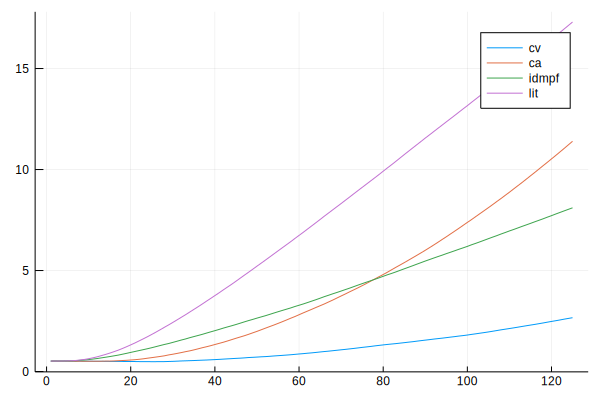

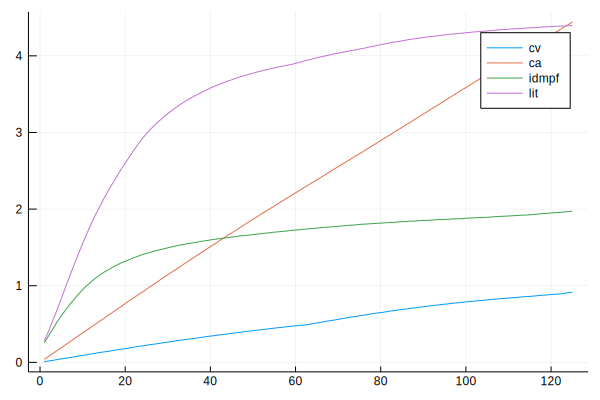

ts = 6875


In [54]:
# rmse results using different scenarios by sampling cars that drive together
# Seeds with cv higher: [33,40,44,49,9,11,13,17,22,25,23,24,26,27,35]
p_pos = plot(); p_vel = plot();
for seed in 4
    Random.seed!(seed)
    horizon = 125;num_veh=10;
    veh_id_list,ts,te = sample_multiple_trajdata_vehicle(num_veh,horizon)
    @show ts
    
    init_vel_model = make_initvel_models(ts,veh_id_list)
    default_model = make_default_models(ts,veh_id_list)
    
    cv_pos_dict,cv_vel_dict=rmse_vid_const(start_step = ts,nsteps=horizon,models=init_vel_model,
        id_list=veh_id_list,const_mode="const_vel");
    ca_pos_dict,ca_vel_dict=rmse_vid_const(start_step = ts,nsteps=horizon,models=init_vel_model,
        id_list=veh_id_list,const_mode="const_accl");
    init_pos_dict, init_vel_dict= run_simulation_extract_rmse(start_step=ts,nsteps=horizon,
        models=init_vel_model,id_list=veh_id_list)
    def_pos_dict, def_vel_dict= run_simulation_extract_rmse(start_step=ts,nsteps=horizon,
        models=default_model,id_list=veh_id_list)
    rmse_pos_cv = rmse_dict2mean(cv_pos_dict); rmse_vel_cv = rmse_dict2mean(cv_vel_dict);
    rmse_pos_init = rmse_dict2mean(init_pos_dict); rmse_vel_init = rmse_dict2mean(init_vel_dict);
    rmse_pos_ca = rmse_dict2mean(ca_pos_dict); rmse_vel_ca = rmse_dict2mean(ca_vel_dict);
    rmse_pos_def = rmse_dict2mean(def_pos_dict); rmse_vel_def = rmse_dict2mean(def_vel_dict)
    
    rmse_pos = [rmse_pos_cv rmse_pos_ca rmse_pos_init rmse_pos_def]
    
    p_pos = plot(rmse_pos,labels = ["cv","ca","idmpf","lit"])
    
    rmse_vel = [rmse_vel_cv rmse_vel_ca rmse_vel_init rmse_vel_def]
    p_vel = plot(rmse_vel,labels = ["cv","ca","idmpf","lit"])
end
display(p_pos)
display(p_vel)

In [ ]:
# Models with default IDM parameters
default_param_models = Dict{Int64,DriverModel}()
scene=get_scene(2000,traj_ngsim)
for k in keys(new_models)
    init_pos,init_vel = get_veh_info(scene,car_id=k)
    default_param_models[k] = IntelligentDriverModel()
end

In [ ]:
# Create drivermodels with initial velocity as desired IDM velocity
init_vel_models = Dict{Int64,DriverModel}()
scene = get_scene(2000,traj_ngsim)
for k in keys(new_models)
    init_pos,init_vel = get_veh_info(scene,car_id = k)
    init_vel_models[k] = IntelligentDriverModel(v_des=init_vel,σ = 1.0,s_min=0.2,T=0.5)
end

In [ ]:
i_scene_list = get_hallucination_scenes(start_step=2000,nsteps=100,models=init_vel_models,id_list=veh_id_list);

In [ ]:
veh_id_list = [756,758,759,761,762,763,765,767,771,773,775,776,778,779,782,784,785]
new_models, = obtain_driver_models(veh_id_list,500,2000,2090)

In [ ]:
# Run the initial velocity IDM models and get the rmse
init_pos_dict, = run_simulation_extract_rmse(start_step=1999,nsteps=100,
timestep=timestep_ngsim,roadway=roadway_ngsim,models=init_vel_models,id_list=veh_id_list);
init = rmse_dict2mean(init_pos_dict);

In [ ]:
default_pos_dict, = run_simulation_extract_rmse(start_step=1999,nsteps=100,
timestep=timestep_ngsim,roadway=roadway_ngsim,models=default_param_models,id_list=veh_id_list);
default_rmse = rmse_dict2mean(default_pos_dict);

In [ ]:
new_pos_dict,new_vel_dict = run_simulation_extract_rmse(start_step=2000,
            nsteps=100,timestep=timestep_ngsim,
            roadway=roadway_ngsim,models=new_models,id_list=veh_id_list);

In [ ]:
# Get the gail rmse values
gail_scenes = load("gail_scenes.jld","gail_scenes")
rmse_pos,rmse_vel,rmse_pos_gail,rmse_vel_gail = 
run_simulation_extract_rmse(gail_scenes,start_step = 2000,nsteps=100,
    timestep=timestep_ngsim,roadway=roadway_ngsim,models=best_models,id_list=newlist);
gail = rmse_dict2mean(rmse_pos_gail);

In [ ]:
gail[1]

In [ ]:
plot(default_rmse[1:50],label="literature",xlabel="step",ylabel="rmse_pos")
plot!(gail[1:50],label="gail")
plot!(init[1:50],label="idm")

# Scripts

In [ ]:
# Just make a video of replay trajectories. Saves video to media folder
make_video(range=2000:2100)

In [ ]:
# Load gail driven scenerecord from jld and overlay on top of ground truth
rec_gail = JLD.load("gail_rec.jld","env_rec")
veh_id_list = [72,75,73,67,69,71,64,59,56,57,62,60,54,55,51,48,43,47,39,37,34,33]
make_vid_truth_halluc(301,400,rec_gail,
    filename = "gail_halluc_removed.mp4",ids_to_keep = veh_id_list)

In [ ]:
# Barrier with gail
rec_barrier = JLD.load("barrier_rec.jld","env_rec")
veh_id_list = [72,75,73,67,69,71,64,59,56,57,62,60,54,55,51,48,43,47,39,37,34,33]
make_vid_truth_halluc(301,400,rec_barrier,filename = "gail_barrier_id39_id51_new.mp4",
    ids_to_keep = veh_id_list)

In [ ]:
# The idea of a barrier. Select some of the vehicles to be driven by IDM with v_des =0
# In this case, vehicle ids 39 and 51. Drive the rest of the vehicles in the list
# using driver models (gail/pf learned idm)
model_multimodels[39].v_des = 0.
model_multimodels[39].σ = 0.
model_multimodels[51].v_des = 0.
model_multimodels[39].σ = 0.
rec_multimodels = run_simulation(100,model_multimodels,299,ids_to_keep=veh_id_list)
make_vid_truth_gail_idm(301,400,rec_barrier,rec_multimodels,
    filename="gail_pf_barrier.mp4",ids_to_keep = veh_id_list)

In [ ]:
#***********************************************************************
#                    Ransalu particle distribution and driving video
#***********************************************************************
function make_video_ransalu(range=nothing;filename="ngsim_$(range).mp4",keep_ids = [])

    frames = Frames(MIME("image/png"), fps=7)
    scene = Scene(500)
    step = 0
    for i in range
        step= step+1
        true_scene = get!(scene,traj_ngsim,i)
        if !isempty(keep_ids)
            keep_vehicle_subset!(true_scene,keep_ids)
        end
        
        colordict = Dict{Int64,Colorant}()
        for veh in true_scene
            colordict[veh.id] = colorant"white"
        end
        
        scene_visual = render(true_scene, roadway_ngsim, 
            [IDOverlay(colorant"red",14),
                TextOverlay(text=["step=$(step)"],font_size=14)
                ],
            cam=CarFollowCamera{Int}(51,4.0),
            #cam=StaticCamera(VecE2(1966600, 570750), 1.4),
            #cam=FitToContentCamera(-0.6),
            car_colors = colordict
        )
        push!(frames,scene_visual)
    end
    write(string("media/for_icra/ransalu/"*filename),frames)    
    
    return nothing
end

function multistep_update_ransalu(num_p::Int64,car_id::Int64,
        start_frame::Int64,last_frame::Int64;p_dist_vid=false)
# Version to plot final particle distribution for every car separately
    startscene = get_ngsim_scene(start_frame)
    startpos,startvel = get_veh_info(startscene,car_id=car_id)

    p_set_dict = sample_init_particles(num_p,v=startvel)
    
    plots = []
    init_p_mat = to_particleMatrix(p_set_dict)
    push!(plots,plot_particles(init_p_mat,0.0))
    
    dt = 0.1 # Multiplies framenum in creating the plot

    iterwise_p_set = [] # Stores particle set at every iteration
    push!(iterwise_p_set,init_p_mat)
    
    for framenum in start_frame:last_frame
        #print("multistep says. Framenum = $(framenum)\n")
        scene = get_ngsim_scene(framenum+1)
        trupos,truvel = get_veh_info(scene,car_id=car_id)
        
        # Get the scene to start hallucinating from
        scene = get_ngsim_scene(framenum)
        p_set_new, weight_vec = update_p_one_step(roadway_ngsim,scene,trupos,p_set_dict,car_id=car_id)
        #p_set_dict = p_set_new
        
            # We need a matrix form to be able to add noise
            # Then we need to convert that back to the dict form at the end
        params = [:v_des,:σ]
        p_set_dict = to_dict_form(params,addnoise(to_particleMatrix(p_set_new),weight_vec))
        
        #set_for_plotting = to_particleMatrix(p_set_new) # Matrix form of particle dict
        
            # With noise addition
        #set_for_plotting = to_particleMatrix(p_set_dict)
        #push!(plots,plot_particles(set_for_plotting,framenum*dt))
        #push!(iterwise_p_set,set_for_plotting)
    end

        # Find the mean particle after filtering is over
        # Defined in `admin.jl`
    mean_particle = find_mean_particle(p_set_dict)
    mp_x = mean_particle[:v_des]
    mp_y = mean_particle[:σ]
    
        # Plot the final particle distribution
    plt = plot_particles(to_particleMatrix(p_set_dict),2.4)
    scatter!(plt,[mp_x],[mp_y],mc="green",markersize=6)
    annotate!(plt,mp_x,mp_y+1.2,"id=$(car_id)")
    savefig(plt,"media/for_icra/ransalu/final_particle_dist_$(car_id).png")
    
        # Plot the initial and final particle distribution together
    plt_initfin = particle_plot_init_fin(init_p_mat,to_particleMatrix(p_set_dict))
    savefig(plt_initfin,"media/for_icra/init_fin_pdist_$(car_id).png")
    
        # Make a plot of the particle distribution evolution
    if p_dist_vid 
        print("Making a particle distribution video")
        date = Dates.now()
        make_gif(plots,filename = "vehid_$(car_id)_$(date).gif") 
    end
    
    return mean_particle,iterwise_p_set
end

function obtain_driver_models_ransalu(veh_id_list,num_particles,start_frame,last_frame)
    models = Dict{Int64,DriverModel}() # key is vehicle id, value is driver model
    final_particles = Dict{Int64,Dict}() # key is vehicle id, value is final particles
    
        # Loop over all the cars and get their corresponding IDM parameters by particle filter
    num_cars = length(veh_id_list)
    num_iters = last_frame-start_frame+2 # NEED TO CONFIRM THIS
    
        # num_iters x num_cars. Every elem is the mean dist of particle set at that iter for that car
    mean_dist_mat = fill(0.,num_iters,num_cars)
    
    for (ii,veh_id) in enumerate(veh_id_list)
        print("obtain_driver_model says: vehicle id = $(veh_id)\n")
        mean_particle, iterwise_p_set = multistep_update_ransalu(num_particles,veh_id,start_frame,last_frame)
        final_particles[veh_id] = mean_particle
        models[veh_id] = IntelligentDriverModel(;mean_particle...)
        
            # Get the mean distance from final particle over iterations
        p_fin = fill(0.,2,1)
        i = 0
        for (k,v) in mean_particle
            i = i+1
            p_fin[i] = v
        end
        
        # num_iters = length(iterwise_p_set) # SHOULD MATCH OUTSIDE LOOP VARIABLE
        mean_dist_over_iters = fill(0.,num_iters,1)
        for (jj,p_mat) in enumerate(iterwise_p_set)
            mean_dist_over_iters[jj,1] = avg_dist_particles(p_mat,p_fin)
        end
        
        mean_dist_mat[:,ii] = mean_dist_over_iters    
    end
    
        # Average over the cars and plot the filtering progress over frames
    #avg_over_cars = mean(mean_dist_mat,dims=2)
    #plot(avg_over_cars)
    
    return models,final_particles,mean_dist_mat
end

    # Perform filtering to enable plot of final distribution
    # Note that the resulting models aren't actually being used for anything
Random.seed!(1)
veh_id_list = [72,75,73,67,69,71,64,59,56,57,62,60,54,55,51,48,43,47,39,37,34,33]
models,particles, = obtain_driver_models_ransalu(veh_id_list,500,300,375)

    # Make video of ground truth
#make_video_ransalu(300:375,keep_ids=veh_id_list)

In [ ]:
# Ransalu plot final particles all in the same plot
# `particles` is a dict with keys as veh_id and value as mean_particle (again a dict)
plt = plot()
for (k,v) in particles
    v_des = v[:v_des];sig = v[:σ]
    scatter!(plt,[v_des],[sig],leg=false,xlabel="v_des(m/s)",ylabel="sigma",xlim=(5,17),ylim=(1,3))
    annotate!(plt,v_des,sig+0.07,Plots.text("id=$k",8))
end
display(plt)
savefig(plt,"media/for_icra/ransalu/mean_particle_vehicles.png")

In [ ]:
# Ransalu: Plot final and initial distb same plot
function particle_plot_init_fin(p_set_mat_init::Array{Float64,2},p_set_mat_fin::Array{Float64,2})
# Plot initial and final particle distributions on same plot
    @assert size(p_set_mat_init,1) <= 3
    plt = Plots.plot()
    xlim = (5,25)
    ylim=(0,4)
    plt = scatter(p_set_mat_init[1,:],p_set_mat_init[2,:],
        mc="grey",label="Initial distribution",
        xlim=xlim,ylim=ylim,xlabel="v_des(m/s)",ylabel="sigma")
    scatter!(plt,p_set_mat_fin[1,:],p_set_mat_fin[2,:],
        mc="blue",label="Final distribution",
        xlim=xlim,ylim=ylim,xlabel="v_des(m/s)",ylabel="sigma")

    return plt
end

veh_id_list = [64]
models,particles, = obtain_driver_models_ransalu(veh_id_list,500,300,375)

In [ ]:
# For RansML to find barycenter from particle sets along with weights
"""
# Example
```julia
veh_id_list = [756,758,759,761,762,763,765,767,771,773,775,776,778,779,782,784,785]
models_nondefault, = obtain_driver_models_ransml(veh_id_list, 500, 2000, 2090)
```
"""
function multistep_update_ransml(num_p::Int64,car_id::Int64,
        start_frame::Int64,last_frame::Int64;p_dist_vid=false)

    startscene = get_ngsim_scene(start_frame)
    startpos,startvel = get_veh_info(startscene,car_id=car_id)

    p_set_dict = sample_init_particles(num_p,v=startvel)
    
    plots = []
    init_p_mat = to_particleMatrix(p_set_dict)
    push!(plots,plot_particles(init_p_mat,0.0))
    
    dt = 0.1 # Multiplies framenum in creating the plot

    iterwise_p_set = [] # Stores particle set at every iteration
    push!(iterwise_p_set,init_p_mat)
    
    iterwise_weights = [] # Stores the weight vec at every iteration
    
    for framenum in start_frame:last_frame
        #print("multistep says. Framenum = $(framenum)\n")
        scene = get_ngsim_scene(framenum+1)
        trupos,truvel = get_veh_info(scene,car_id=car_id)
      
        # Get the scene to start hallucinating from
        scene = get_ngsim_scene(framenum)
        p_set_new, weight_vec = update_p_one_step(roadway_ngsim,scene,trupos,p_set_dict,car_id=car_id)
        #p_set_dict = p_set_new

            # We need a matrix form to be able to add noise
            # Then we need to convert that back to the dict form at the end
        params = [:v_des,:σ]
        p_set_dict = to_dict_form(params,addnoise(to_particleMatrix(p_set_new),weight_vec))
        
        #set_for_plotting = to_particleMatrix(p_set_new) # Matrix form of particle dict
        
            # With noise addition
        set_for_plotting = to_particleMatrix(p_set_dict)
        push!(plots,plot_particles(set_for_plotting,framenum*dt))
        push!(iterwise_p_set,set_for_plotting)
        push!(iterwise_weights,weight_vec)
    end

        # Find the mean particle after filtering is over
        # Defined in `admin.jl`
    mean_particle = find_mean_particle(p_set_dict)

        # Make a plot of the particle distribution evolution
    if p_dist_vid 
        print("Making a particle distribution video")
        date = Dates.now()
        make_gif(plots,filename = "vehid_$(car_id)_$(date).gif") 
    end

    final_particle_set = iterwise_p_set[end]
    final_weight_set = iterwise_weights[end]
    
    final_p_w = vcat(final_particle_set,final_weight_set')
    
    npzwrite("$(car_id).npy",final_p_w)
    return mean_particle,iterwise_p_set
end

function obtain_driver_models_ransml(veh_id_list,num_particles,start_frame,last_frame)
    models = Dict{Int64,DriverModel}() # key is vehicle id, value is driver model
    final_particles = Dict{Int64,Dict}() # key is vehicle id, value is final particles
    
        # Loop over all the cars and get their corresponding IDM parameters by particle filter
    num_cars = length(veh_id_list)
    num_iters = last_frame-start_frame+2 # NEED TO CONFIRM THIS
    
        # num_iters x num_cars. Every elem is the mean dist of particle set at that iter for that car
    mean_dist_mat = fill(0.,num_iters,num_cars)
    
    for (ii,veh_id) in enumerate(veh_id_list)
        #print("obtain_driver_model says: vehicle id = $(veh_id)\n")
        mean_particle, iterwise_p_set = multistep_update_ransml(num_particles,veh_id,start_frame,last_frame)
        final_particles[veh_id] = mean_particle
        models[veh_id] = IntelligentDriverModel(;mean_particle...,T=0.2,s_min=0.5)
        
            # Get the mean distance from final particle over iterations
        p_fin = fill(0.,2,1)
        i = 0
        for (k,v) in mean_particle
            i = i+1
            p_fin[i] = v
        end
        
        # num_iters = length(iterwise_p_set) # SHOULD MATCH OUTSIDE LOOP VARIABLE
        mean_dist_over_iters = fill(0.,num_iters,1)
        for (jj,p_mat) in enumerate(iterwise_p_set)
            mean_dist_over_iters[jj,1] = avg_dist_particles(p_mat,p_fin)
        end
        
        mean_dist_mat[:,ii] = mean_dist_over_iters    
    end
    
        # Average over the cars and plot the filtering progress over frames
    #avg_over_cars = mean(mean_dist_mat,dims=2)
    #plot(avg_over_cars)
    
    return models,final_particles, mean_dist_mat
end

# for paper

In [ ]:
# Capture the filtering progress
    # Perform filtering
veh_id_list = [23,27,20,21,19,17,35,14,13,11,10,6,9,3]
models_multimodel, particles_multimodel = obtain_driver_models(veh_id_list,500,11,60);

    # Save to csv
avg_val = mean(mean_dist_mat_all,dims=2)
CSV.write("media/for_icra/pf_prog.csv",  DataFrame(avg_val), writeheader=false)

    # Make a plot
plot(mean(mean_dist_mat_all,dims=2),leg=false,xlabel="iteration number",ylabel="mean distance from final particle",
title="Particle filtering progress")
savefig("media/for_icra/pf_progress.png")

In [ ]:
# Case 2: Frame number 2000 to 2090 for filtering
veh_id_list = [756,758,759,761,762,763,765,767,771,773,775,776,778,779,782,784,785]
best_models,best_seed,min_cost = search_models(num_particles=500,filter_start = 2000,
    filter_last=2090,veh_id_list = veh_id_list)

In [5]:
# function: convert dict to mat for final particles
"""
    function final_particles_dict2mat(final_particles)
- Take `final_particles`, a dict with keys as veh ids and values as particle
- The particle is again a dict with keys as `:v_des` and `:σ`
- Convert to a matrix with each row a different vehicles particle
- Write to csv

# Examples
```julia
# Treat intial vel as v_des and random value between 0.1 and 2. as sigma
veh_id_list = [23,27,20,21,19,17,35,14,13,11,10,6,9,3]
scene = get_scene(11,traj_highd)
keep_vehicle_subset!(scene,veh_id_list)
final_particles = Dict{Int64,Dict}()
for veh in scene
    v = veh.state.v
    sig = rand(0.1:0.1:2.0)
    final_particles[veh.id] = Dict(:v_des=>v,:σ=>sig)
end
# Deploy the function to write to csv
final_particles_dict2mat(final_particles)
```
"""
function final_particles_dict2mat(final_particles)
    num_veh = length(keys(final_particles))
    particles_mat = fill(0.,(num_veh,2))
    for (i,(k,v)) in enumerate(final_particles)
        particles_mat[i,1] = v[:v_des]
        particles_mat[i,2] = v[:σ]
    end
    CSV.write("media/for_icra/csv_files/highd_final_particles.csv",DataFrame(particles_mat))
    return nothing
end

final_particles_dict2mat

In [8]:
# Treat intial vel as v_des and random value between 0.1 and 2. as sigma
veh_id_list = [23,27,20,21,19,17,35,14,13,11,10,6,9,3]
scene = get_scene(11,traj_highd)
keep_vehicle_subset!(scene,veh_id_list)
final_particles = Dict{Int64,Dict}()
for veh in scene
    v = veh.state.v
    sig = rand(0.1:0.1:2.0)
    final_particles[veh.id] = Dict(:v_des=>v,:σ=>sig)
end
# Deploy the function to write to csv
final_particles_dict2mat(final_particles)

In [59]:
# Multiple scenarios to generate table results for ngsim cv,ca,idmpf,def
seeds = [33,40,44,49,9,11,13,17,22,25,23,24,26,27,35]
rmse_pos_end = fill(0.,length(seeds),4)
rmse_vel_end = fill(0.,length(seeds),4)
for (i,seed) in enumerate(seeds)
    print("i = $i,")
    Random.seed!(seed)
    horizon = 125;num_veh=10;
    veh_id_list,ts,te = sample_multiple_trajdata_vehicle(num_veh,horizon)
    
    init_vel_model = make_initvel_models(ts,veh_id_list)
    default_model = make_default_models(ts,veh_id_list)
    
    cv_pos_dict,cv_vel_dict=rmse_vid_const(start_step = ts,nsteps=horizon,models=init_vel_model,
        id_list=veh_id_list,const_mode="const_vel");
    ca_pos_dict,ca_vel_dict=rmse_vid_const(start_step = ts,nsteps=horizon,models=init_vel_model,
        id_list=veh_id_list,const_mode="const_accl");
    init_pos_dict, init_vel_dict= run_simulation_extract_rmse(start_step=ts,nsteps=horizon,
        models=init_vel_model,id_list=veh_id_list)
    def_pos_dict, def_vel_dict= run_simulation_extract_rmse(start_step=ts,nsteps=horizon,
        models=default_model,id_list=veh_id_list)
    rmse_pos_cv = rmse_dict2mean(cv_pos_dict); rmse_vel_cv = rmse_dict2mean(cv_vel_dict);
    rmse_pos_init = rmse_dict2mean(init_pos_dict); rmse_vel_init = rmse_dict2mean(init_vel_dict);
    rmse_pos_ca = rmse_dict2mean(ca_pos_dict); rmse_vel_ca = rmse_dict2mean(ca_vel_dict);
    rmse_pos_def = rmse_dict2mean(def_pos_dict); rmse_vel_def = rmse_dict2mean(def_vel_dict)
    
    rmse_pos_end[i,:] = [rmse_pos_cv[end] rmse_pos_ca[end] rmse_pos_init[end] rmse_pos_def[end]]
    rmse_vel_end[i,:] = [rmse_vel_cv[end] rmse_vel_ca[end] rmse_vel_init[end] rmse_vel_def[end]]
end

i = 1,i = 2,i = 3,i = 4,WARNING: insuffcient sampling ids in sample_multiple_trajdata_vehicle
i = 5,i = 6,i = 7,i = 8,i = 9,i = 10,i = 11,i = 12,i = 13,i = 14,i = 15,WARNING: insuffcient sampling ids in sample_multiple_trajdata_vehicle


In [60]:
    # Compute the rmse_vel metrics
for i in 1:size(rmse_pos_end,2)
    rmse_vec = rmse_pos_end[:,i]
    mean,bound = compute_table_metrics(rmse_vec)
    @show mean,bound
end
    # Compute the rmse_pos metrics
for i in 1:size(rmse_vel_end,2)
    rmse_vec = rmse_vel_end[:,i]
    mean,bound = compute_table_metrics(rmse_vec)
    @show mean,bound
end

(mean, bound) = (2.4158541825685678, 1.647831925590635)
(mean, bound) = (11.013272635933406, 1.920289040268103)
(mean, bound) = (8.015061939201624, 3.3387706957892704)
(mean, bound) = (18.301676315121394, 9.033201820785806)
(mean, bound) = (0.9424445786253145, 0.5744786534392908)
(mean, bound) = (4.398355087862471, 0.6065483951934747)
(mean, bound) = (2.1350948696188237, 0.655543026118875)
(mean, bound) = (4.596809434368788, 2.4641688678946716)
